In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import torch # import pytorch
from torch import nn
import numpy as np
import csv # In order to read .csv data file
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
os.listdir()
os.chdir('drive/')
os.chdir('MyDrive/')
os.chdir("Purdue-Second Year/Fall Semester/CS 50100")

In [109]:
training_unrate = [] # Initialize list for univariate unemployment rate
training_month_dict = {} # Initialize a dictionary for unemployment rate sorted by months
validation_unrate = []
validation_month_dict = {}
# Open the .csv and extract unemployment data
with open ('macro_monthly_clean.csv', newline = '') as c:
  reader = csv.DictReader(c)

  for row in reader:
    date_ls = row['DATE'].split('-')
    year_interest = int(date_ls[0])
    if (2000 >= year_interest): # Include everything for training except 2021 (use for validation)
      # month_ls = row['DATE'].split('-')
      if date_ls[1] not in training_month_dict.keys(): # If the month is not within the dictionary keys
        training_month_dict[date_ls[1]] = [] # Initialize value list
      training_month_dict[date_ls[1]].append(row['unrate'])
      # unrate.append(float(row['unrate']))
    elif (2000 < year_interest < 2021):
      if date_ls[1] not in validation_month_dict.keys():
        validation_month_dict[date_ls[1]] = []
      validation_month_dict[date_ls[1]].append(row['unrate'])
# print(len(unrate))
print("Length of validation: " + str(len(validation_month_dict['01'])))
print(validation_month_dict) # Each month should have 40 entries (40 years worth of data for each month)
dict_ls = [training_month_dict, validation_month_dict]
list_ls = [training_unrate, validation_unrate]
for k in range(len(dict_ls)):
  for key in dict_ls[k].keys():
    for i in range(len(dict_ls[k][key])):
      list_ls[k].append(float(dict_ls[k][key][i]))

# Here, the unrate variable contains a sequence of the unemployment rate data sorted by months (January, February, March...)

Length of validation: 20
{'01': ['4.2', '5.7', '5.8', '5.7', '5.3', '4.7', '4.6', '5.0', '7.8', '9.8', '9.1', '8.3', '8.0', '6.6', '5.7', '4.8', '4.7', '4.0', '4.0', '3.5'], '02': ['4.2', '5.7', '5.9', '5.6', '5.4', '4.8', '4.5', '4.9', '8.3', '9.8', '9.0', '8.3', '7.7', '6.7', '5.5', '4.9', '4.6', '4.1', '3.8', '3.5'], '03': ['4.3', '5.7', '5.9', '5.8', '5.2', '4.7', '4.4', '5.1', '8.7', '9.9', '9.0', '8.2', '7.5', '6.7', '5.4', '5.0', '4.4', '4.0', '3.8', '4.4'], '04': ['4.4', '5.9', '6.0', '5.6', '5.2', '4.7', '4.5', '5.0', '9.0', '9.9', '9.1', '8.2', '7.6', '6.2', '5.4', '5.1', '4.5', '4.0', '3.7', '14.8'], '05': ['4.3', '5.8', '6.1', '5.6', '5.1', '4.6', '4.4', '5.4', '9.4', '9.6', '9.0', '8.2', '7.5', '6.3', '5.6', '4.8', '4.4', '3.8', '3.7', '13.3'], '06': ['4.5', '5.8', '6.3', '5.6', '5.0', '4.6', '4.6', '5.6', '9.5', '9.4', '9.1', '8.2', '7.5', '6.1', '5.3', '4.9', '4.3', '4.0', '3.6', '11.1'], '07': ['4.6', '5.8', '6.2', '5.5', '5.0', '4.7', '4.7', '5.8', '9.5', '9.4', '9.0',

In [110]:
# Define our LSTM model
class LSTMModel (nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, 1) # Output is a single value for regression
  def forward (self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :]) # Retrieve output from last time step
    return out

# Define hyperparameters here
input_size = 1 # Univariate data
hidden_size = 64 # Number of LSTM units (neurons)
num_layers = 1 # Number of LSTM layers

# Create instance of LSTM model
model = LSTMModel(input_size, hidden_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.00010
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # Define learning rate here

In [111]:
# Convert the unemployment rate data into a numpy array
training_data = np.array(training_unrate)
validation_data = np.array(validation_unrate)
# Convert numpy array into torch tensor
training_data_tensor = torch.tensor(training_data, dtype = torch.float32)
validation_data_tensor = torch.tensor(validation_data, dtype = torch.float32)

# Defining input sequence length (to predict next time step's value)
sequence_length = 9 # Since data is structured monthly and there are 40/2 entries for each month, use 9 months to predict the next 1 month
training_sequences = []

# For training
for i in range(len(training_data) - sequence_length):
    seq = training_data_tensor[i:i+sequence_length]
    target = training_data_tensor[i+sequence_length]
    training_sequences.append((seq, target)) # Sequences contain a list of tuples (each tuple contains 'seq', the input sequence (list) and 'target' the target value (float))

# Convert time-series data and respective output targets into PyTorch tensors
training_inputs = torch.stack([x[0] for x in training_sequences]) # Input (1st element within tuple containing list)
training_targets = torch.stack([x[1] for x in training_sequences]) # Target output (2nd element within tuple containing float)

# Creating TensorDataset for training
training_dataset = TensorDataset(training_inputs, training_targets)

validation_sequences = []

# For validation
for i in range(len(validation_data) - sequence_length):
  seq = validation_data_tensor[i:i+sequence_length]
  target = validation_data_tensor[i+sequence_length]
  validation_sequences.append((seq, target))

# Convert time-series data and respective output targets into PyTorch tensors
validation_inputs = torch.stack([x[0] for x in validation_sequences]) # Input (1st element within tuple containing list)
validation_targets = torch.stack([x[1] for x in validation_sequences]) # Target output (2nd element within tuple containing float)

# Creating TensorDataset for validation
validation_dataset = TensorDataset(validation_inputs, validation_targets)

# Create a dataloader
batch_size = 64 # Adjust this based on compute memory
training_data_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle = True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)



In [112]:
# Code for Training
num_epochs = 200

training_loss_ls = []  # Initialize training loss list
validation_loss_ls = []  # Initialize validation loss list

for epoch in range(num_epochs):
    for batch_inputs, batch_targets in training_data_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Perform the forward pass
        outputs = model(batch_inputs.unsqueeze(2))  # Add an extra dimension to accommodate input size

        # Compute Training Loss
        loss = criterion(outputs, batch_targets.unsqueeze(1))  # Add an extra dimension for output

        # Perform backpropagation
        loss.backward()
        optimizer.step()

    # Validation Phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in validation_data_loader:
            outputs = model(batch_inputs.unsqueeze(2))
            validation_loss += criterion(outputs, batch_targets.unsqueeze(1))

    # Calculate validation loss and store it for analysis
    validation_loss /= len(validation_data_loader)

    # Append both training and validation losses
    training_loss_ls.append(loss.item())
    validation_loss_ls.append(validation_loss.item())

    # Print losses for each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {validation_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')


Epoch [1/200], Training Loss: 42.1264, Validation Loss: 41.2796
Epoch [2/200], Training Loss: 39.5368, Validation Loss: 41.0376
Epoch [3/200], Training Loss: 42.3940, Validation Loss: 40.7949
Epoch [4/200], Training Loss: 48.2484, Validation Loss: 40.5502
Epoch [5/200], Training Loss: 42.2385, Validation Loss: 40.3035
Epoch [6/200], Training Loss: 42.1776, Validation Loss: 40.0541
Epoch [7/200], Training Loss: 40.5237, Validation Loss: 39.8020
Epoch [8/200], Training Loss: 38.1033, Validation Loss: 39.5466
Epoch [9/200], Training Loss: 42.1977, Validation Loss: 39.2870
Epoch [10/200], Training Loss: 35.9496, Validation Loss: 39.0218
Epoch [11/200], Training Loss: 38.6269, Validation Loss: 38.7508
Epoch [12/200], Training Loss: 44.4105, Validation Loss: 38.4733
Epoch [13/200], Training Loss: 40.3039, Validation Loss: 38.1875
Epoch [14/200], Training Loss: 37.1933, Validation Loss: 37.8930
Epoch [15/200], Training Loss: 35.6293, Validation Loss: 37.5884
Epoch [16/200], Training Loss: 34.

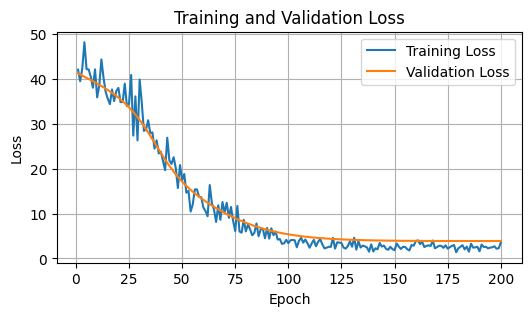

Model Parameters: 
Input Size: 1
Hidden Size: 64
Num layers: 1
Sequence Length: 9
Batch Size:64
Learning Rate: 0.0001


In [113]:
# Create array to represent training epochs
epochs = range(1, len(training_loss_ls) + 1)

# Plot both training and validation losses
plt.figure(figsize=(6, 3))
plt.plot(epochs, training_loss_ls, label='Training Loss', linestyle='-')
plt.plot(epochs, validation_loss_ls, label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Add a legend to distinguish between training and validation losses
plt.grid(True)
plt.show()

print("Model Parameters: ")
print("Input Size: " + str(input_size))
print("Hidden Size: " + str(hidden_size))
print("Num layers: " + str(num_layers))
print("Sequence Length: " + str(sequence_length))
print("Batch Size:" + str(batch_size))
print("Learning Rate: " + str(learning_rate))
